# K-Fold Cross-Validation

### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# Diamonds dataset

### Data preparation

In [2]:
# importing data
data_path= 'data/diamonds.csv'
diamonds = pd.read_csv(data_path)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['cut'], prefix='cut', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['color'], prefix='color', drop_first=True)],axis=1)
diamonds = pd.concat([diamonds, pd.get_dummies(diamonds['clarity'], prefix='clarity', drop_first=True)],axis=1)
diamonds.drop(['cut','color','clarity'], axis=1, inplace=True)

### Preparing objects for modelling

In [6]:
# Notice that we are not doing train-test split
target_name = 'price'
robust_scaler = RobustScaler()
X = diamonds.drop('price', axis=1)
X = robust_scaler.fit_transform(X)
y = diamonds[target_name]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

### Training our model

In [18]:
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=123, n_jobs=-1)

In [28]:
# K-fold cross-validation. cv is K
scores = cross_validate(estimator=RF,X=X,y=y,
                        scoring=['neg_root_mean_squared_error','r2'],
                        cv=10, n_jobs=-1)

In [29]:
# cross_validate returns scores of the estimator for each run of the cross validation
# Save the result in a dataframe
# Scoring in cross_validate turn the negated value of the error metric, therefore -1*scores
scores = pd.DataFrame(scores)
scores['test_neg_root_mean_squared_error'] = -1*scores['test_neg_root_mean_squared_error']
scores

,fit_time,score_time,test_neg_root_mean_squared_error,test_r2
0,3.249975,0.020195,613.082885,0.538356
1,12.853868,0.021162,671.283545,0.672623
2,12.813254,0.021324,1195.159098,0.386492
3,13.177665,0.021194,1544.071366,0.569584
4,12.935636,0.030979,2450.019749,0.653762
5,12.777246,0.020961,1173.465386,0.958354
6,13.065642,0.020800,156.530980,-0.315683
7,13.125645,0.022590,253.126777,-0.215285
8,12.669992,0.020518,340.042958,0.303920
9,1.920757,0.016279,444.069030,0.397857


In [30]:
# Get better error metric for etimator by taking the average of all the error metrics
print("Mean test RMSE:", round(scores['test_neg_root_mean_squared_error'].mean()))
print("Mean test R-squared:", scores['test_r2'].mean())

Mean test RMSE: 884
Mean test R-squared: 0.39499810614847386


# Comparing Models With k-fold Cross-validation

In [7]:
## KNN
knn = KNeighborsRegressor(n_neighbors=20, weights='distance', metric='euclidean', n_jobs=-1)
knn_test_rmse = cross_validate(estimator=knn,X=X,y=y,
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, n_jobs=-1)['test_score']

## Random Forests
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
RF_test_rmse = cross_validate(estimator=RF,X=X,y=y,
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, n_jobs=-1)['test_score']

## Boosting
boosting = AdaBoostRegressor(n_estimators=50, learning_rate=0.05, random_state=55)  
boosting_test_rmse = cross_validate(estimator=boosting,X=X,y=y,
                             scoring='neg_root_mean_squared_error', 
                             cv=10, n_jobs=-1)['test_score']

In [8]:
rmse_models = -1*pd.DataFrame({'KNN':knn_test_rmse,
                           'RandomForest': RF_test_rmse,
                           'Boosting':boosting_test_rmse})
rmse_models

,KNN,RandomForest,Boosting
0,791.341790,612.299888,1368.077964
1,751.940025,671.339107,1948.536894
2,1082.890593,1188.782428,1711.355015
3,1690.250195,1535.876854,2724.080512
4,3669.156525,2399.836246,3169.139772
5,1748.409822,1163.112754,1901.658833
6,215.927570,156.944338,196.999740
7,349.136057,252.853509,718.874125
8,492.726743,344.941915,787.960591
9,692.616289,437.664407,825.228003


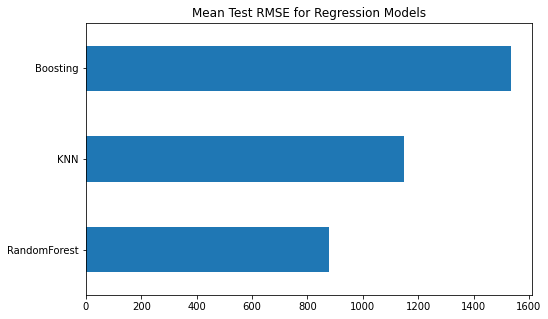

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
rmse_models.mean().sort_values().plot(kind='barh', ax=ax)
ax.set_title('Mean Test RMSE for Regression Models');

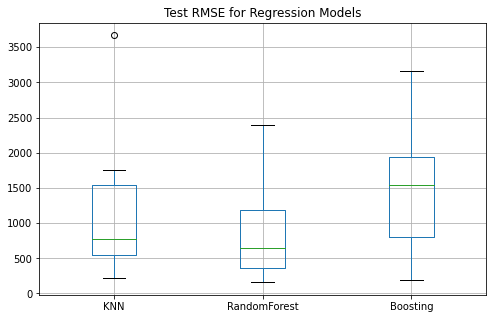

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
rmse_models.boxplot(ax=ax)
ax.set_title('Test RMSE for Regression Models');

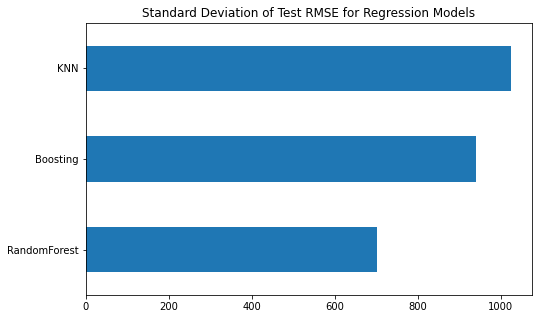

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
rmse_models.std().sort_values().plot(kind='barh', ax=ax)
ax.set_title('Standard Deviation of Test RMSE for Regression Models');

# Hyper-Parameter tunning in scikit-learn

In [14]:
# Split dataset so we don't test hyperparameters on the entire dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

### Defining the tuning grid

* **n_estimators**: The number of trees in the forest.

* **max_features**: The number of features to consider when looking for the best split. Posible choices: n_features, sqrt(n_features), log2(n_features).
    
* **max_depth**: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

Model we have been using:

RandomForestRegressor(n_estimators=50, max_depth=16, max_features= 'auto', random_state=55, n_jobs=-1)

In [15]:
RF = RandomForestRegressor(random_state=55, n_jobs=-1)

In [16]:
# Parameter grid
parameter_grid = {'n_estimators': [25,50,75,100], 
                  'max_depth': [10,15,20,30],
                  'max_features': ['auto','sqrt']}

In [19]:
# Exhaustive grid search 
RF_classifier = GridSearchCV(estimator=RF, param_grid=parameter_grid, refit=True,
                             scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)

RF_classifier.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(n_jobs=-1, random_state=55),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 30],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [25, 50, 75, 100]},
             scoring='neg_root_mean_squared_error')

In [20]:
# Save results in dataframe
results = pd.DataFrame(RF_classifier.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,5.245262,0.263346,0.014575,0.003226,10,auto,25,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",-775.073922,-794.965660,...,-779.816602,-807.124672,-812.953020,-808.877125,-843.593514,-810.968210,-777.286187,-796.250271,24.630058,28
1,9.401757,0.077123,0.022163,0.002538,10,auto,50,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",-770.466528,-787.843303,...,-780.387063,-798.508328,-805.058906,-807.928164,-838.342108,-804.136052,-772.020409,-791.865057,22.854691,27
2,14.633062,1.488442,0.037274,0.011346,10,auto,75,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",-771.557194,-783.449659,...,-780.012648,-794.052392,-802.410094,-805.923170,-838.698847,-806.388965,-773.751612,-790.425812,23.605099,26
3,20.826907,1.968056,0.035904,0.001790,10,auto,100,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",-770.782093,-782.829575,...,-778.820611,-792.492137,-799.878427,-802.088790,-837.256936,-804.689593,-771.059466,-788.796538,23.124079,25
4,1.388405,0.067014,0.013654,0.000800,10,sqrt,25,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",-865.476992,-914.377550,...,-912.026113,-904.616316,-921.670190,-907.768215,-932.328141,-879.231877,-874.067750,-899.767195,21.061245,32


In [21]:
# Most imporant result: show best hyperparameters
RF_classifier.best_params_

{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100}

In [22]:
# Show how to implement best estimator
RF_classifier.best_estimator_

RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=55)

## Comparing the best model from grid search with our last model using the test set

In [26]:
## Random Forests
RF_model1 = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=123, n_jobs=-1)
RF_model1.fit(X_train, y_train)
RF_model1_test_rmse = mean_squared_error(y_pred=RF_model1.predict(X_test), y_true=y_test, squared=False)

## Random Forest with tuned parameters 
RF_tuned_test_rmse = mean_squared_error(y_pred=RF_classifier.predict(X_test), y_true=y_test, squared=False)

In [27]:
rmse_models = pd.Series({'Not Tuned': RF_model1_test_rmse, 'Tuned Model':RF_tuned_test_rmse})

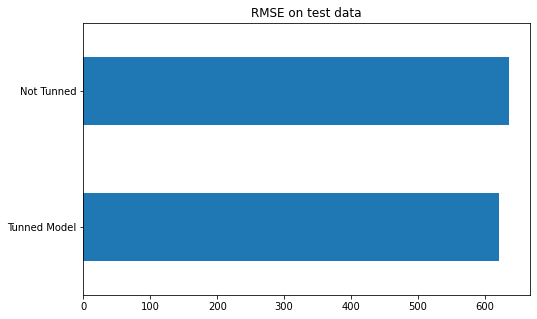

In [28]:
fig, ax = plt.subplots(figsize=(8,5))
rmse_models.sort_values().plot(kind='barh', ax=ax)
ax.set_title('RMSE on test data');

In [30]:
# Calculate percentage of improvement
100 * (RF_model1_test_rmse - RF_tuned_test_rmse) / RF_model1_test_rmse

2.2695170222689125

# Credit card default dataset 

### Preparing the data

In [34]:
default = pd.read_csv('./data/credit_card_default.csv', index_col="ID")
default.rename(columns=lambda x: x.lower(), inplace=True)
default.rename(columns={'pay_0':'pay_1','default payment next month':'default'}, inplace=True)
# Base values: female, other_education, not_married
default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')
default.drop('education', axis=1, inplace=True)

default['male'] = (default['sex']==1).astype('int')
default.drop('sex', axis=1, inplace=True)

default['married'] = (default['marriage'] == 1).astype('int')
default.drop('marriage', axis=1, inplace=True)

# For pay_n features if >0 then it means the customer was delayed on that month
pay_features = ['pay_' + str(i) for i in range(1,7)]
for p in pay_features:
    default[p] = (default[p] > 0).astype(int)

### Preparing objects for modelling

In [35]:
target_name = 'default'
X_credit = default.drop('default', axis=1)
feature_names = X_credit.columns
robust_scaler = RobustScaler()
X_credit = robust_scaler.fit_transform(X_credit)
y_credit = default[target_name]

In [36]:
RF_credit = RandomForestClassifier(n_estimators=35, max_depth=20, random_state=55, 
                                   max_features='sqrt', n_jobs=-1)

In [37]:
scores_credit = cross_validate(estimator=RF_credit, X=X_credit, y=y_credit,
                        scoring=['accuracy','precision','recall'],
                        cv=10, n_jobs=-1)

In [38]:
scores_credit = pd.DataFrame(scores_credit)
scores_credit

,fit_time,score_time,test_accuracy,test_precision,test_recall
0,3.585075,0.028227,0.799000,0.580902,0.329819
1,3.609497,0.028556,0.803667,0.602740,0.331325
2,3.520208,0.025631,0.804000,0.602703,0.335843
3,3.482778,0.027314,0.799667,0.584906,0.326807
4,3.558910,0.025636,0.810667,0.621212,0.370482
5,3.482099,0.027440,0.812000,0.606383,0.429217
6,3.620599,0.029840,0.825000,0.680628,0.392157
7,3.578688,0.028399,0.822000,0.699690,0.340875
8,1.198270,0.020513,0.813000,0.651786,0.330317
9,1.180290,0.023503,0.809333,0.626741,0.339367


In [39]:
scores_credit[['test_accuracy','test_precision','test_recall']].mean()

test_accuracy     0.809833
test_precision    0.625769
test_recall       0.352621
dtype: float64

In [40]:
scores_credit[['test_accuracy','test_precision','test_recall']].std()

test_accuracy     0.008734
test_precision    0.039852
test_recall       0.034126
dtype: float64

### Exercise: compare the 4 models used with the credit card default dataset using cross-validation, then pick the best one